In [1]:
from qupath_processing.io import (
    read_qupath_annotations, read_cells_coordinate,
    )

from collections import defaultdict
from os import listdir
from os.path import isfile, join
from itertools import islice
import csv
import numpy as np
import geojson
import pandas as pd
import openpyxl
from qupath_processing.utilities import NotValidImage
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from shapely.geometry import Polygon



In [2]:
def read_cells_information(file_path):
    """
    Read file that contains cell positions and create cells centroids x,y position and layer classification
    :param file_path:(str) Path to the file that contains cell positions exported form QuPath
    :return:
        tuple:
            - cells_centroid_x np.array of shape (number of cells, ) of type float
            - cells_centroid_y np.array of shape (number of cells, ) of type float
            - layer_classification
    """
    workbook = openpyxl.Workbook()
    worksheets = workbook.worksheets[0]

    with open(file_path, 'r', encoding="utf-8") as data:
        reader = csv.reader(data, delimiter='\t')
        for row in reader:
            worksheets.append(row)
    data = worksheets.values
    cols = next(data)[1:]
    data = list(data)
    idx = [r[0] for r in data]
    data = (islice(r, 1, None) for r in data)
    df = pd.DataFrame(data, index=idx, columns=cols)
    return df

In [3]:
s1_annotation_df = read_cells_information('../../QuPathProject/layerBoundary/Results/annotation.txt')

In [4]:
s1_annotation_df.head()

,Name,Class,Parent,ROI,Centroid X µm,Centroid Y µm,Num Detections,Num Layer 1,Num Layer 2,Num Layer 3,Num Layer 4,Num Layer 5,Num Layer 6 a,Num Layer 6b,Num points,Area µm^2,Perimeter µm
SLD_0000560.vsi - 20x_01,Layer 6 a,Layer 6 a,Image,Polygon,7377.8,2055.2,122,0,0,0,0,0,122,0,NaN,31156.2,680.46
SLD_0000560.vsi - 20x_01,TOP_RIGHT,,Image,Points,7842.4,749.1,0,0,0,0,0,0,0,0,1,NaN,NaN
SLD_0000560.vsi - 20x_01,Layer 2,Layer 2,Image,Geometry,7197.7,1124.3,67,0,67,0,0,0,0,0,NaN,34993.8,779.72
SLD_0000560.vsi - 20x_01,BOTTOM_RIGHT,,Image,Points,8034.4,2411,0,0,0,0,0,0,0,0,1,NaN,NaN
SLD_0000560.vsi - 20x_01,TOP_LEFT,,Image,Points,6919.8,943.94,0,0,0,0,0,0,0,0,1,NaN,NaN


In [5]:
points_coordinates = []
for s1_label in ['TOP_LEFT', 'TOP_RIGHT', 'BOTTOM_LEFT', 'BOTTOM_RIGHT']:
    annotation = s1_annotation_df[s1_annotation_df["Name"] == s1_label]
    xs = annotation['Centroid X µm'].to_numpy(dtype=float)
    ys = annotation['Centroid Y µm'].to_numpy(dtype=float)
    points_coordinates.append([xs, ys])

In [6]:
cell_position_file_path = '../../QuPathProject/layerBoundary/Results/detection.txt'
pixel_size =  0.3460130331522824
df = read_cells_information(cell_position_file_path)

In [7]:
df.head()

,Name,Class,Parent,ROI,Centroid X µm,Centroid Y µm,Area µm^2,Length µm,Circularity,Solidity,...,Smoothed: 25 µm: Cluster mean: Distance to annotation Outside Pia µm,Smoothed: 25 µm: Cluster mean: Delaunay: Num neighbors,Smoothed: 25 µm: Cluster mean: Delaunay: Mean distance,Smoothed: 25 µm: Cluster mean: Delaunay: Median distance,Smoothed: 25 µm: Cluster mean: Delaunay: Max distance,Smoothed: 25 µm: Cluster mean: Delaunay: Min distance,Smoothed: 25 µm: Cluster mean: Delaunay: Mean triangle area,Smoothed: 25 µm: Cluster mean: Delaunay: Max triangle area,Smoothed: 25 µm: Cluster size,Smoothed: 25 µm: Nearby detection counts
SLD_0000560.vsi - 20x_01,Layer 6 a,Layer 6 a,S1HL,Polygon,7446.8,1931.8,519.1575,119.0178,0.4606,0.9236,...,1011.509,5.906,17.7875,17.5442,25.8039,10.2107,124.934,219.6439,5362.9995,3
SLD_0000560.vsi - 20x_01,Layer 6 a,Layer 6 a,S1HL,Polygon,7643.1,1911.7,498.2072,121.7856,0.4221,0.9254,...,1011.5092,5.906,17.7875,17.5442,25.8039,10.2107,124.934,219.6439,5363,8
SLD_0000560.vsi - 20x_01,Layer 6 a,Layer 6 a,S1HL,Polygon,7635.7,1958.3,449.0102,105.8713,0.5034,0.9374,...,1011.5091,5.906,17.7875,17.5442,25.8039,10.2107,124.934,219.6439,5362.9995,6
SLD_0000560.vsi - 20x_01,Layer 6 a,Layer 6 a,S1HL,Polygon,7288.7,2006.5,444.7007,101.0271,0.5475,0.9637,...,1011.509,5.906,17.7875,17.5442,25.8039,10.2107,124.934,219.6439,5363,5
SLD_0000560.vsi - 20x_01,Layer 6 a,Layer 6 a,S1HL,Polygon,7337.5,1911.6,441.4681,103.1033,0.5219,0.9359,...,1011.509,5.906,17.7875,17.5442,25.8039,10.2107,124.934,219.6439,5363,4


In [8]:
def plot_cells_in_layers(dataframe, s1_coordinate):
    for layer_name in ['Layer 1', 'Layer 2', 'Layer 3', 'Layer 4', 'Layer 5', 'Layer 6 a', 'Layer 6b']:
        print(f' layer_name {layer_name}')
        layer = df[df["Class"] == layer_name]
        xs = layer['Centroid X µm'].to_numpy(dtype=float)
        ys = layer['Centroid Y µm'].to_numpy(dtype=float)
        print(f' xs mean = {xs.mean()}, ys min/amx = {ys.min()}/{ys.max()}')
        plt.scatter(xs,ys, s=1)
    for point in s1_coordinate:
        plt.scatter(point[0], point[1], s=30)
    plt.show()
    """
    for layer_name in ['Layer 1', 'Layer 2', 'Layer 3', 'Layer 4', 'Layer 5', 'Layer 6 a', 'Layer 6b']:
        print(f' layer_name {layer_name}')
        layer = df[df["Class"] == layer_name]
        xs = layer['Centroid X µm'].to_numpy(dtype=float)
        ys = layer['Centroid Y µm'].to_numpy(dtype=float)
        plt.hist(ys)
        plt.title(layer_name + " ys")
        plt.show()
        print(f" Standard deviation {ys.std()}")
        print(f' ys mean - standard deviation = {ys.mean()-ys.std()}')
        print(f' ys mean + standard deviation = {ys.mean()+ys.std()}')
    """


 layer_name Layer 1
 xs mean = 7383.1, ys min/amx = 770.61/2666.0
 layer_name Layer 2
 xs mean = 7407.674303405573, ys min/amx = 800.26/2362.8
 layer_name Layer 3
 xs mean = 7410.688149350648, ys min/amx = 964.47/2438.8
 layer_name Layer 4
 xs mean = 7443.725525525526, ys min/amx = 999.01/1941.6
 layer_name Layer 5
 xs mean = 7466.461716171618, ys min/amx = 1112.4/2456.4
 layer_name Layer 6 a
 xs mean = 7529.6436936936925, ys min/amx = 1154.1/2668.8
 layer_name Layer 6b
 xs mean = 7554.846036161336, ys min/amx = 2189.5/2789.0


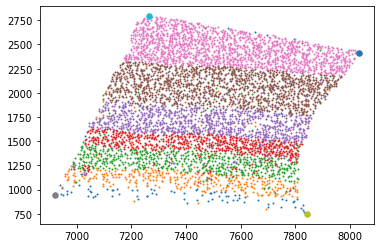

In [9]:
plot_cells_in_layers(df, points_coordinates)

In [10]:
def get_layer_y_bounderies(_xs, _ys):
    points = np.zeros((len(_xs),2))
    points[:,0] = _xs
    points[:,1] = _ys
    hull = ConvexHull(points)
    return points, hull

In [65]:
def plot_cells_in_layers_filter_with_std(dataframe):

    hull_dict = {}
    plt.figure(figsize=(10,10))
    for layer_name in ['Layer 1', 'Layer 2', 'Layer 3', 'Layer 4', 'Layer 5', 'Layer 6 a', 'Layer 6b']:
        layer = df[df["Class"] == layer_name]
        ys = layer['Centroid Y µm'].to_numpy(dtype=float)
        indices = np.where((ys > ys.mean()-ys.std()*2) & (ys < ys.mean()+ys.std()*2))
        xs = layer['Centroid X µm'].to_numpy(dtype=float)[indices]
        ys = layer['Centroid Y µm'].to_numpy(dtype=float)[indices]
        plt.scatter(xs,ys, s=2)
        
        
        points, hull = get_layer_y_bounderies(xs,ys)
        hull_dict[layer_name] = (points, hull)
        plt.plot(points[:,0], points[:,1], 'o')
        for simplex in hull.simplices:
            plt.plot(points[simplex, 0], points[simplex, 1], 'k-')
        mean_y = points[hull.simplices][:][:,1][:,1].min()    
        plt.axhline(mean_y)
    
        
    plt.show()
    return hull_dict


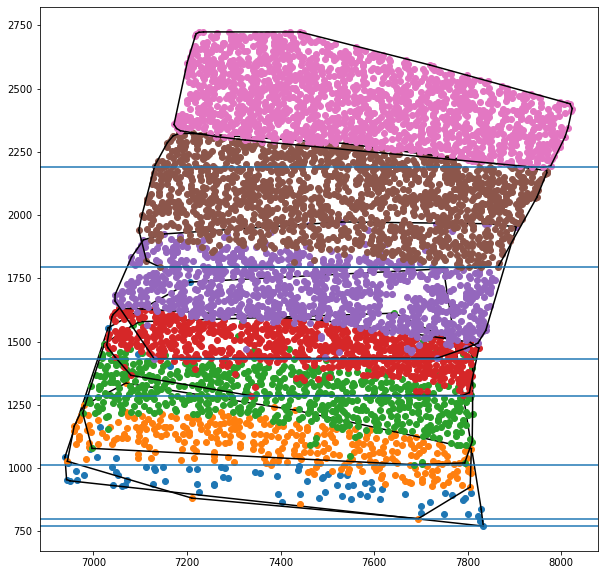

In [66]:
hull_dict= plot_cells_in_layers_filter_with_std(df)

In [13]:
def point_in_hull(point, hull, tolerance=1e-12):
    return all(
        (np.dot(eq[:-1], point) + eq[-1] <= tolerance)
        for eq in hull.equations)